# 数据预处理

## 导入必要的包

In [2]:
# 导入必要的库

import pandas as pd
import os
# StandardScaler 对数据进行标准化
from sklearn.preprocessing import StandardScaler
import numpy as np
# 导入现成算法包
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
# train_test_split 将数据分割为训练集和测试集
from sklearn.model_selection import train_test_split
# 评估指标相关函数
from sklearn.metrics import (
    accuracy_score,  # 用于计算分类的准确率
    precision_score,  # 用于计算精确率
    recall_score,  # 用于计算召回率
    f1_score,  # 用于计算 F1 分数
    confusion_matrix,  # 计算混淆矩阵
    classification_report  # 输出分类报告，包括多个评估指标
)
# 可视化图表
import matplotlib.pyplot as plt
# seaborn 是基于 matplotlib 的可视化库
import seaborn as sns
# SMOTE 用于解决数据集中的类别不平衡问题
from imblearn.over_sampling import SMOTE
import time


## 加载数据，为每个文件添加标签

In [3]:
# 加载数据函数，加载指定文件夹内的数据文件，并按顺序合并
def load_te_data(folder_path):
    data = []  # 存储数据
    labels = []  # 存储标签
    
    # 获取文件夹中所有文件的列表，并按文件名进行排序（保证文件顺序一致）
    files = sorted(os.listdir(folder_path)) 
    
    # 遍历每个文件
    for file in files:
        if file.endswith('.dat'):  # 只处理以 '.dat' 结尾的文件
            file_path = os.path.join(folder_path, file)  # 拼接文件路径
            # 读取数据文件，文件是空格分隔的数据，并且不包含列头
            df = pd.read_csv(file_path, sep='\\s+', header=None)
            # 从文件名中提取标签，标签位于文件名中的第2到第3个字符（例如 'd00.dat' 提取标签 '00'）
            label = int(file[1:3])  
            data.append(df)  # 添加数据
            # 将标签添加到 labels 列表中，标签数组的大小和数据的行数一致
            labels.append(np.full((df.shape[0],), label)) 
    
    # 将所有数据合并为一个大的 DataFrame，并将所有标签合并为一个大的数组
    return pd.concat(data, axis=0), np.concatenate(labels, axis=0)

# 加载训练集和测试集数据
train_data, train_labels = load_te_data('TE_train')  
test_data, test_labels = load_te_data('TE_test') 

# 标签添加到数据集中
train_data['Label'] = train_labels
test_data['Label'] = test_labels

# 确保训练集和测试集的特征对齐，找到训练集和测试集共有的列 (intersection求两个 Index 对象之间的交集)
common_columns = train_data.columns.intersection(test_data.columns).drop('Label')
train_data = train_data[common_columns.to_list() + ['Label']]  # 保留共同特征列和标签列
test_data = test_data[common_columns.to_list() + ['Label']]  # 保留共同特征列和标签列

scaler = StandardScaler()  # 创建 StandardScaler 对象，用于标准化数据
X_train = scaler.fit_transform(train_data.drop('Label', axis=1))  # 对训练集进行标准化，去掉标签列
X_test = scaler.transform(test_data.drop('Label', axis=1)) 

# 提取训练集和测试集的标签(用于验证)
y_train = train_data['Label'].values
y_test = test_data['Label'].values

print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")


训练集大小: (10132, 52), 测试集大小: (21120, 52)


## 检查类别分布
类别分别不均衡会导致计算出错，这里调整类别分布

In [4]:
# 定义函数检查类别分布
def check_class_distribution(y_train, y_test):
    # 使用 np.unique 获取训练集和测试集中的每个类别及其出现的次数
    # 返回值 unique_train 是训练集中不同类别的标签，counts_train 是每个类别的出现次数
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)  # 测试集类别分布
    
    print("训练集类别分布:", dict(zip(unique_train, counts_train)))
    print("测试集类别分布:", dict(zip(unique_test, counts_test)))

check_class_distribution(y_train, y_test)  # 调用，打印训练集和测试集的类别分布

# 训练集类别不平衡，使用 SMOTE 技术进行过采样处理类别不平衡问题
smote = SMOTE(random_state=42)  # 初始化 SMOTE 对象，random_state(固定随机种子)

# 对训练集进行过采样，生成新的样本，使得少数类样本的数量增加
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


训练集类别分布: {np.int64(0): np.int64(52), np.int64(1): np.int64(480), np.int64(2): np.int64(480), np.int64(3): np.int64(480), np.int64(4): np.int64(480), np.int64(5): np.int64(480), np.int64(6): np.int64(480), np.int64(7): np.int64(480), np.int64(8): np.int64(480), np.int64(9): np.int64(480), np.int64(10): np.int64(480), np.int64(11): np.int64(480), np.int64(12): np.int64(480), np.int64(13): np.int64(480), np.int64(14): np.int64(480), np.int64(15): np.int64(480), np.int64(16): np.int64(480), np.int64(17): np.int64(480), np.int64(18): np.int64(480), np.int64(19): np.int64(480), np.int64(20): np.int64(480), np.int64(21): np.int64(480)}
测试集类别分布: {np.int64(0): np.int64(960), np.int64(1): np.int64(960), np.int64(2): np.int64(960), np.int64(3): np.int64(960), np.int64(4): np.int64(960), np.int64(5): np.int64(960), np.int64(6): np.int64(960), np.int64(7): np.int64(960), np.int64(8): np.int64(960), np.int64(9): np.int64(960), np.int64(10): np.int64(960), np.int64(11): np.int64(960), np.int64(12): n

# 有监督训练

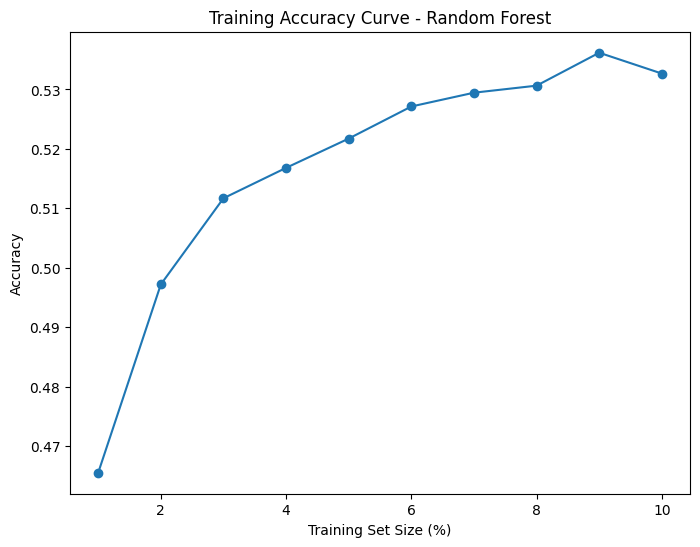

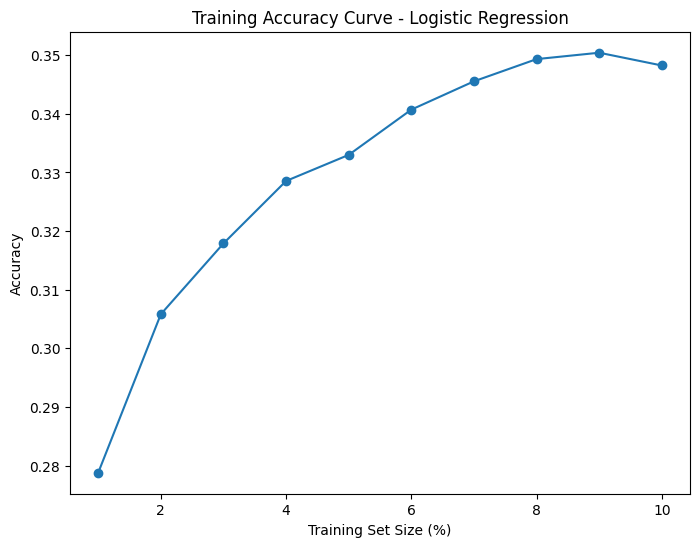

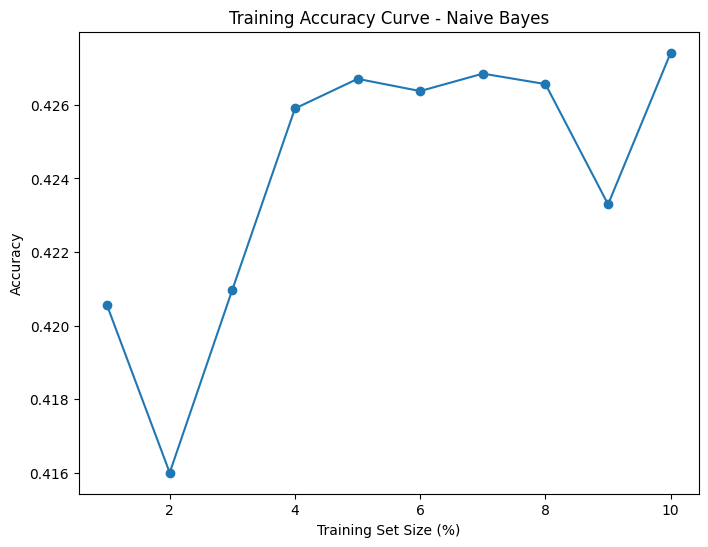

In [5]:
# 训练并评估模型函数
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name, track_loss=False):
    start_time = time.time()
    # 训练模型：使用训练集(X_train, y_train)来拟合模型
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    # 对测试集进行预测，得到预测结果
    y_pred = model.predict(X_test)
    
    # 准确率，预测正确的样本占总样本的比例
    accuracy = accuracy_score(y_test, y_pred)
    # 精确度，正确预测为正样本的比例（对类别不平衡时有意义）
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    # 召回率，所有实际为正样本的预测为正样本的比例
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    # F1 分数，精确度和召回率的调和平均
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    # 混淆矩阵， 表示预测结果与实际标签之间的关系
    conf_matrix = confusion_matrix(y_test, y_pred)
    # 分类报告：包含了准确率、精确度、召回率、F1分数等指标的详细报告
    report = classification_report(y_test, y_pred, zero_division=0)
    
    # 将分类报告保存到文本文件中
    with open(f"{model_name}_classification_report.txt", "w") as f:
        f.write(f"classification_report ({model_name}):\n")
        f.write(report)

    # 返回一个字典，包含模型评估的所有指标及混淆矩阵
    return {
        "model_name": model_name,
        "train_time": train_time,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "conf_matrix": conf_matrix,
    }

# 追踪训练过程中的准确率变化
def plot_training_curve(model, X_train, y_train, X_test, y_test, model_name, track_loss=False):
    scores = []
    losses = []
    
    # 在训练集上分配不同的训练集大小来观察模型的表现
    for i in range(1, 11):
        train_size = i / 10 if i < 10 else None  # 训练集大小从10%到100%
        # train_test_split 随机选取一部分训练数据
        X_subset, _, y_subset, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
        # 训练模型
        model.fit(X_subset, y_subset)
        
        
        if track_loss:
            # 追踪损失（适用于无法直接计算准确率的模型）
            losses.append(model.score(X_subset, y_subset))  
        else:
            # 追踪测试集上的准确率
            scores.append(model.score(X_test, y_test))

    plt.figure(figsize=(8, 6))
    if track_loss:
        plt.plot(range(1, 11), losses, marker='o')
        plt.title(f"Training Loss Curve - {model_name}")
        plt.ylabel("Loss")
    else:
        plt.plot(range(1, 11), scores, marker='o')
        plt.title(f"Training Accuracy Curve - {model_name}")
        plt.ylabel("Accuracy")
    
    plt.xlabel("Training Set Size (%)") 
    plt.show()

# 初始化模型
nb = GaussianNB()
# n_estimators=100 设置100棵树，class_weight='balanced' 处理类别不平衡
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
# max_iter=200 设置最大迭代次数
lr = LogisticRegression(max_iter=200, class_weight='balanced', random_state=42)

# 训练并评估模型
results = []
for model, name in zip([rf, lr, nb], ["Random Forest", "Logistic Regression", "Naive Bayes"]):
    # 调用 train_and_evaluate 函数，训练并评估模型
    result = train_and_evaluate(model, X_train, y_train, X_test, y_test, name)
    results.append(result) 
    plot_training_curve(model, X_train, y_train, X_test, y_test, name, track_loss=False)

# 无监督训练

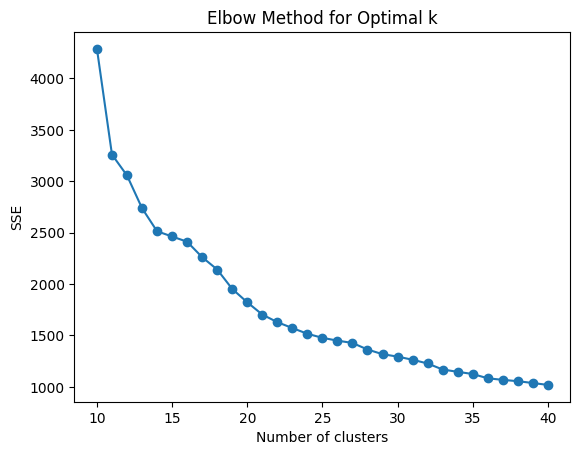

In [6]:
# 肘部法则来选择合适的簇数
def plot_elbow_method(X_train, max_k):
    sse = []  # 存储每个簇数k对应的误差平方和(SSE)（每个点到其簇中心的距离的平方和）
    
    # 遍历从10到max_k之间的所有簇数k
    for k in range(10, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)  # 初始化KMeans模型，设定簇数k
        kmeans.fit(X_train)  # 用训练数据X_train进行训练
        sse.append(kmeans.inertia_)  # 获取当前簇数下的误差平方和(SSE)
    
    # 绘制SSE与簇数k的关系曲线
    plt.plot(range(10, max_k + 1), sse, marker='o')  
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters') 
    plt.ylabel('SSE') 
    plt.show() 

# 导入必要的指标与工具
from sklearn.metrics import precision_score, recall_score, f1_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment

# 初始化KMeans模型，簇数为训练集标签的类别数（假设已知标签数目）
kmeans = KMeans(n_clusters=len(np.unique(y_train)), random_state=42)

# 定义评估KMeans聚类的函数
def evaluate_kmeans(kmeans, X, y_true):
    start_time = time.time()
    # 对输入数据X进行KMeans聚类
    kmeans.fit(X)
    train_time = time.time() - start_time
    # 获取KMeans模型对X的预测标签
    y_pred = kmeans.predict(X)

    num_classes = len(np.unique(y_true))  # 获取实际标签的类别数
    contingency_matrix = confusion_matrix(y_true, y_pred, labels=range(num_classes))  # 计算混淆矩阵
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)

    # 将预测标签重新映射为真实标签，方便计算统计
    mapping = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}
    y_pred_aligned = np.array([mapping[label] for label in y_pred])

    # 计算评估指标
    accuracy = accuracy_score(y_true, y_pred_aligned) 
    ari = adjusted_rand_score(y_true, y_pred)  # 计算调整rand指数，评估聚类结果与真实标签的一致性
    precision = precision_score(y_true, y_pred_aligned, average="weighted", zero_division=0)
    recall = recall_score(y_true, y_pred_aligned, average="weighted", zero_division=0) 
    f1 = f1_score(y_true, y_pred_aligned, average="weighted", zero_division=0) 
    conf_matrix = confusion_matrix(y_true, y_pred_aligned)

    return train_time, accuracy, ari, precision, recall, f1, conf_matrix

# 标准化数据（均值为0，方差为1）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 使用肘部法则来选择最优的簇数，最大簇数设置为40
plot_elbow_method(X_train_scaled, max_k=40) 

# 初始化KMeans模型，选择合适的簇数（肘部法则结果显示n_clusters=21为合适）
kmeans = KMeans(n_clusters=21, random_state=42, n_init=10)  # 设置簇数为21，n_init=10表示算法运行10次，选择最佳结果

# 训练并评估KMeans模型
train_time_kmeans, accuracy_kmeans, ari_kmeans, precision_kmeans, recall_kmeans, f1_kmeans, conf_matrix_kmeans = evaluate_kmeans(kmeans, X_test_scaled, y_test)

results.append({
    "model_name": "KMeans",  # 模型名称
    "train_time": train_time_kmeans,  # 训练时间
    "accuracy": accuracy_kmeans,  # 准确率
    "precision": precision_kmeans,  # 精确度
    "recall": recall_kmeans,  # 召回率
    "f1_score": f1_kmeans,  # F1分数
    "conf_matrix": conf_matrix_kmeans,  # 混淆矩阵
})


# 混淆矩阵可视化


模型评估结果：
            model_name  train_time  accuracy  precision    recall  f1_score
0        Random Forest   12.467565  0.535985   0.639697  0.535985  0.561899
1  Logistic Regression    1.016800  0.352699   0.376137  0.352699  0.347596
2          Naive Bayes    0.008554  0.423864   0.529848  0.423864  0.449922
3               KMeans    1.074739  0.206723   0.292593  0.206723  0.212951


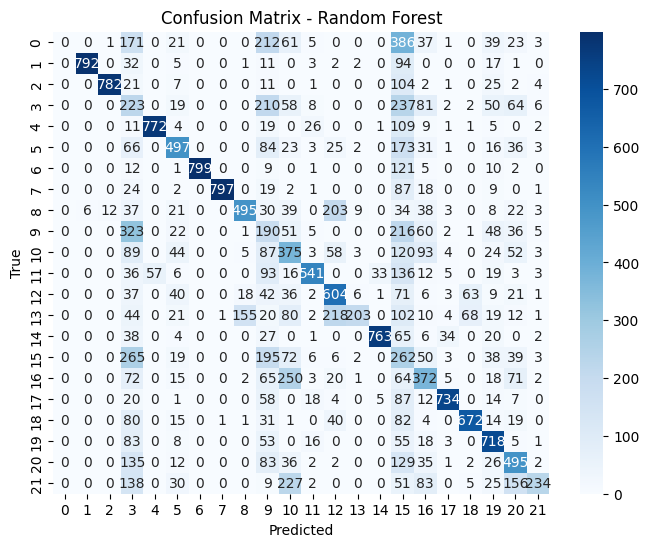

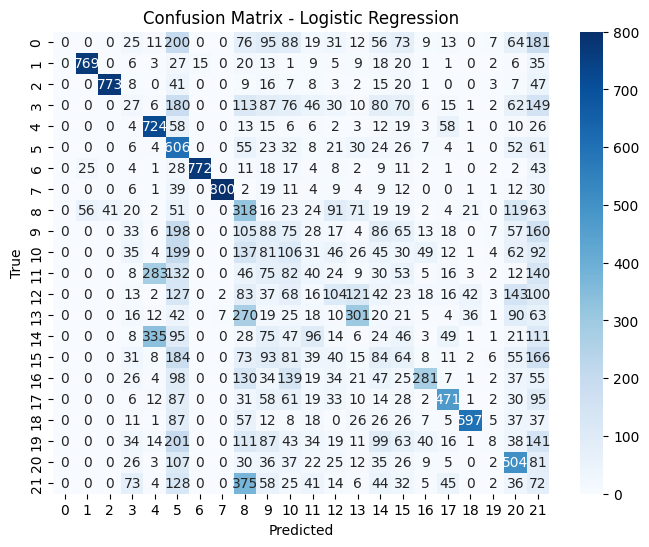

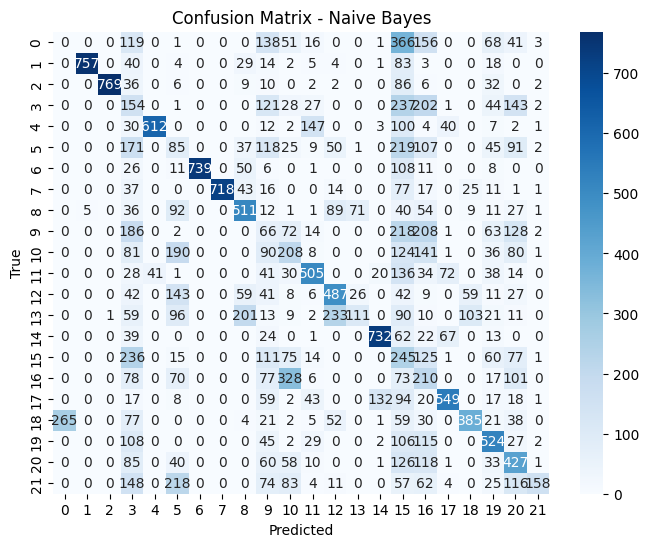

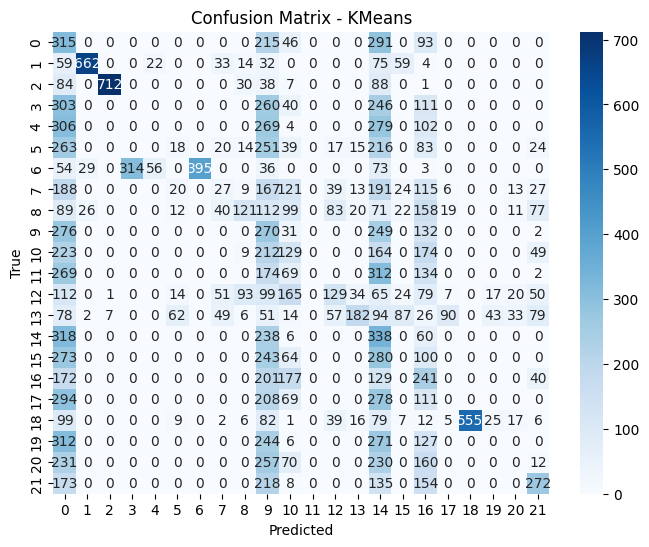


结果已保存到文件 model_evaluation_results.csv


In [7]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 创建一个包含各个模型评估结果的 DataFrame
results_df = pd.DataFrame(results)

results_df = results_df[["model_name", "train_time", "accuracy", "precision", "recall", "f1_score"]]

print("\n模型评估结果：")
print(results_df)

for result in results:
    if result['conf_matrix'] is not None:
        plt.figure(figsize=(8, 6))
        # 使用 Seaborn 绘制热力图，annot=True 显示数字，fmt='d' 格式化为整数
        sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {result['model_name']}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

results_df.to_csv("model_evaluation_results.csv", index=False)
print("\n结果已保存到文件 model_evaluation_results.csv")
